In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from datetime import date
sns.set_style("whitegrid")

%matplotlib inline

In [14]:
def get_atlanta_flights(year=2017):
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        annual_flights = pd.read_sql("""
            SELECT 
                f.origin_airport_id as airport_id,
                f.origin_airport_sequence_id as sequence_id,
                a.display_airport_name as airport_name,
                f.origin as origin_airport,
                f.year as year,
                f.month as month,
                count(f.flights) AS departures,
                SUM(f.departure_was_delayed_15) AS departure_delays,
                sum(f.diverted) as diverted,
                sum(f.cancelled) as cancelled
            FROM 
                flights AS f
            JOIN
                airports as a
            ON
                f.origin_airport_sequence_id = a.airport_sequence_id
            WHERE 
                f.year = :year AND
                a.display_airport_name = 'Hartsfield-Jackson Atlanta International'
            GROUP BY 
                f.origin_airport_id, f.origin_airport_sequence_id, a.display_airport_name, f.origin, f.year, f.month
        """, conn, 
        params={'year': year})
        
    return annual_flights.sort_values('departures', ascending=False)

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
atl = get_atlanta_flights(2017)
atl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 2 to 1
Data columns (total 10 columns):
airport_id          12 non-null int64
sequence_id         12 non-null int64
airport_name        12 non-null object
origin_airport      12 non-null object
year                12 non-null int64
month               12 non-null int64
departures          12 non-null int64
departure_delays    12 non-null int64
diverted            12 non-null int64
cancelled           12 non-null int64
dtypes: int64(8), object(2)
memory usage: 1.0+ KB


In [15]:
atl.head(15)

,airport_id,sequence_id,airport_name,origin_airport,year,month,departures,departure_delays,diverted,cancelled
2,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,3,97371,14163,183,564
6,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,7,96558,23883,234,213
4,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,5,96471,20457,213,201
5,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,6,96150,23976,186,411
7,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,8,95697,16956,252,552
3,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,4,93366,21126,153,4290
0,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,1,90414,18528,234,1929
9,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,10,89526,12591,99,69
8,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,9,85923,10236,129,3246
11,10397,1039705,Hartsfield-Jackson Atlanta International,ATL,2017,12,84891,15480,129,4467


In [11]:
atl.departures.sum()

1093965

In [25]:
def get_annual_departures_by_airport(year=2017):
    """ Return a dataframe flight counts by day of week and year  """
    engine = create_engine('sqlite:///./../../data/processed/airlines.db')
    
    with engine.connect() as conn:
        annual_flights = pd.read_sql("""
            SELECT 
                f.origin_airport_sequence_id as airport_id,
                a.display_airport_name as airport_name,
                f.origin as origin_airport,
                f.year as year,
                f.month as month,
                count(f.origin_airport_sequence_id) AS departures,
                SUM(f.departure_was_delayed_15) AS departure_delays
            FROM 
                flights AS f
            JOIN
                airports as a
            ON
                f.origin_airport_sequence_id = a.airport_seq_id
            WHERE 
                f.year = :year 
            GROUP BY 
                f.origin_airport_id, a.display_airport_name, f.origin, f.year, f.month
        """, conn, 
        params={'year': year})
        
    return annual_flights.sort_values('departures', ascending=False)

# Get summary data for selected date range, counting flights delayed more than 15 minutes on departure
departures = get_annual_departures_by_airport(2017)
departures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3551 entries, 203 to 839
Data columns (total 7 columns):
airport_id          3551 non-null int64
airport_name        3551 non-null object
origin_airport      3551 non-null object
year                3551 non-null int64
month               3551 non-null int64
departures          3551 non-null int64
departure_delays    3551 non-null int64
dtypes: int64(5), object(2)
memory usage: 221.9+ KB


In [51]:
f = departures.groupby(['airport_name', 'origin_airport', 'year']).sum()[['departures', 'departure_delays']]

f['departure_delay_fraction'] = f['departure_delays'] / f['departures']

f = f.sort_values('departures', ascending=False)
f.head(25)

,,,departures,departure_delays,departure_delay_fraction
airport_name,origin_airport,year,,,
Hartsfield-Jackson Atlanta International,ATL,2017,364655,64570,0.177071
Chicago O'Hare International,ORD,2017,266460,50536,0.189657
Denver International,DEN,2017,223165,40158,0.179948
Los Angeles International,LAX,2017,214297,49707,0.231954
Dallas/Fort Worth International,DFW,2017,181208,33879,0.186962
San Francisco International,SFO,2017,174631,40548,0.232192
Phoenix Sky Harbor International,PHX,2017,154508,25150,0.162775
McCarran International,LAS,2017,151720,32235,0.212464
Seattle/Tacoma International,SEA,2017,137176,22101,0.161114


In [28]:
total_flights = f['departures'].sum()
total_delays = f['departure_delays'].sum()
rate_of_delay = total_delays / total_flights

print("Total Domestic Departures (2017): ", "{:,}".format(total_flights))
print("Total Delayed Departures (2017):  ", "{:,}".format(total_delays))
print("Percent of Flights Delayed (2017): ", '{:5.2f}%'.format(rate_of_delay * 100))

Total Domestic Departures (2017):  5,674,621
Total Delayed Departures (2017):   1,013,845
Percent of Flights Delayed (2017):  17.87%


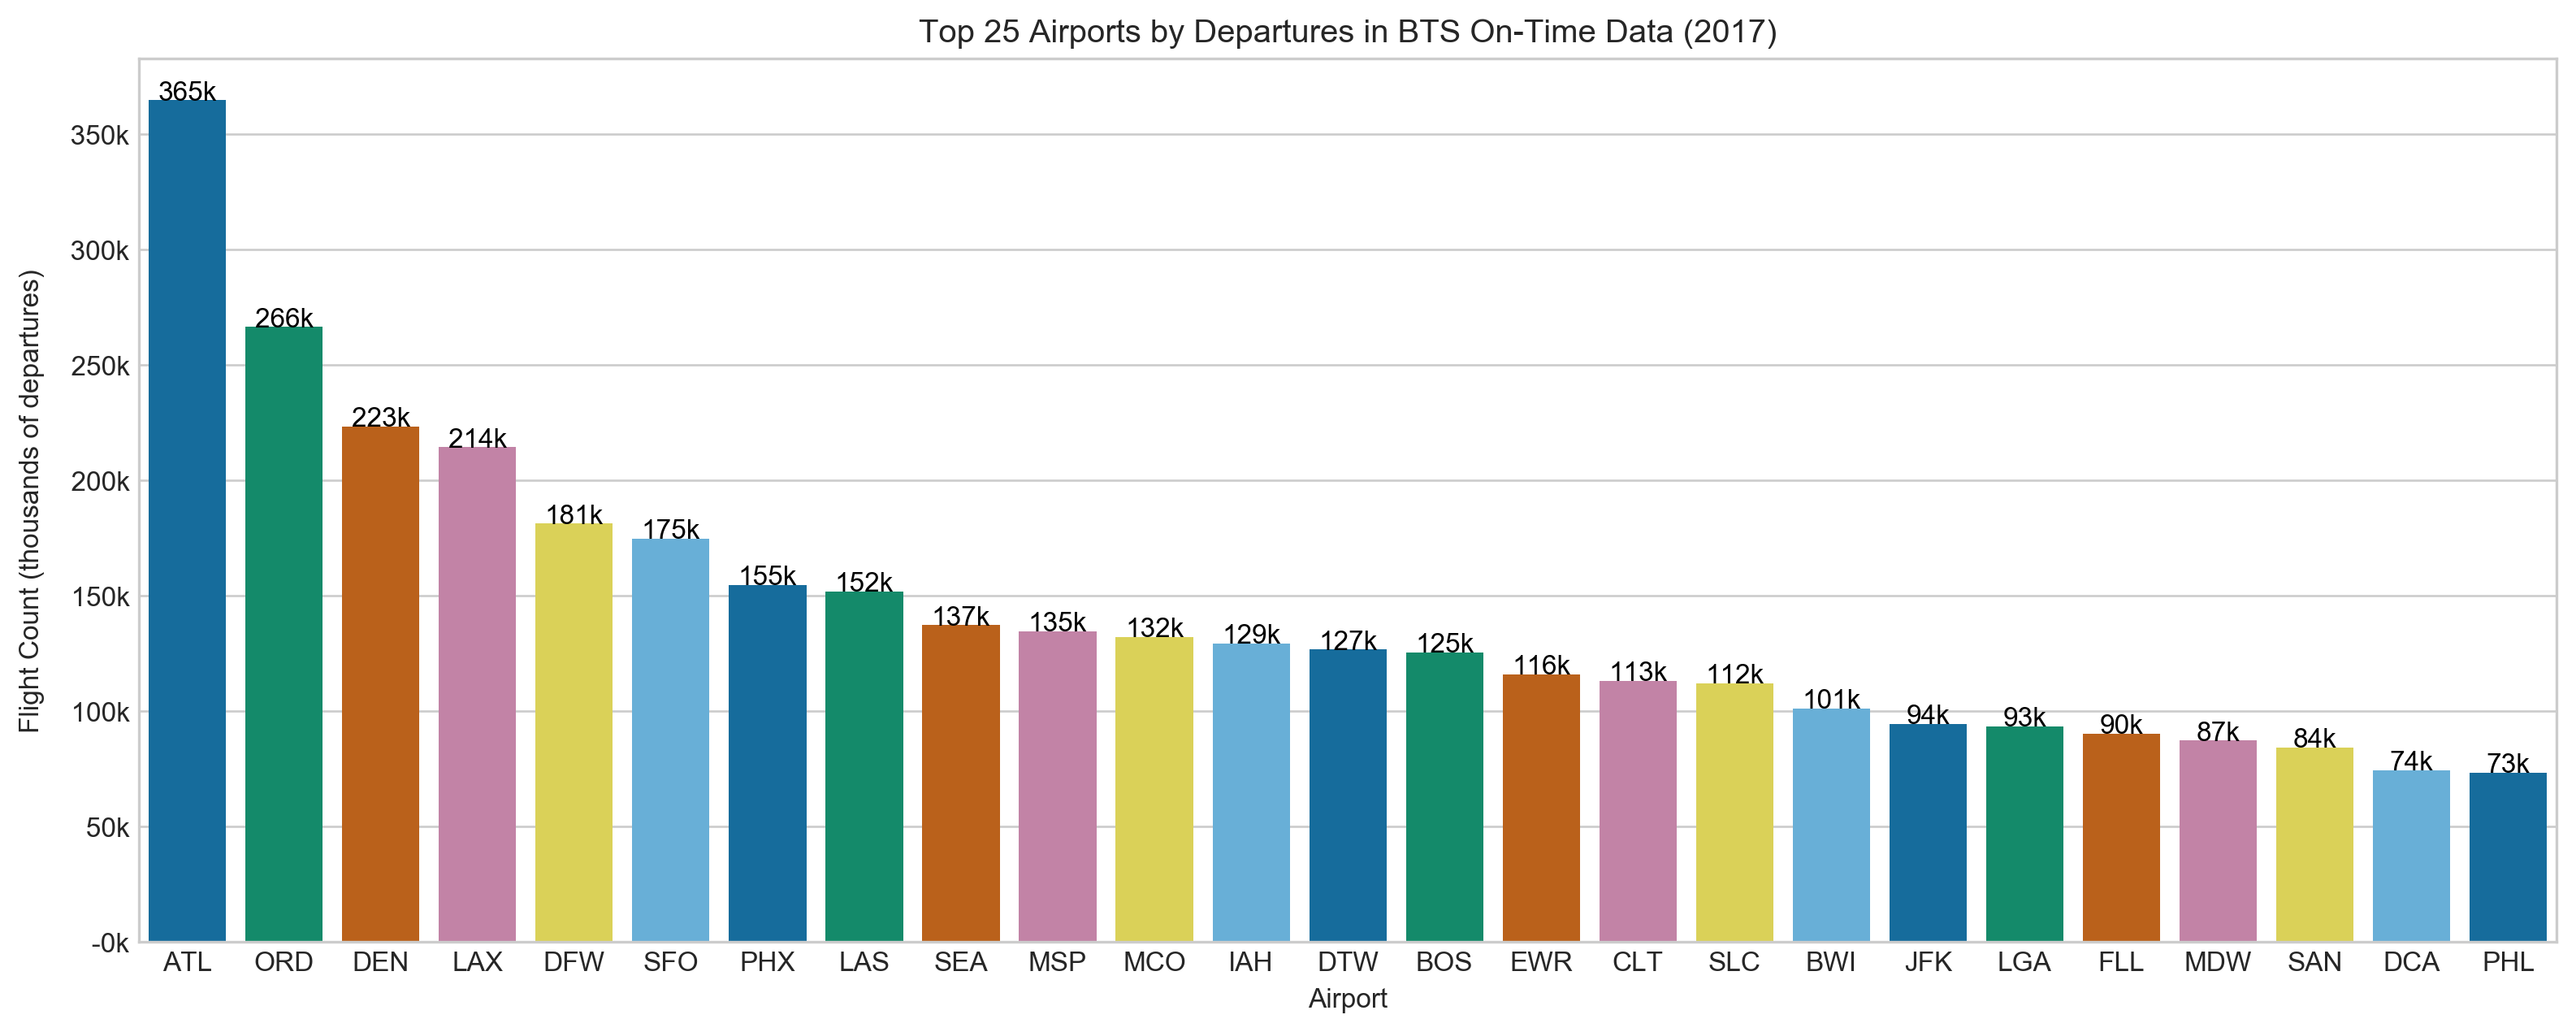

In [63]:
def plot_top_airports_flight_counts(plot_data):
    count = len(plot_data)
    plot_data = plot_data.reset_index()
    ax, fig = plt.subplots(figsize=(16, 6), dpi=240)
    color = sns.color_palette('colorblind')
    
    ax = sns.barplot(x='origin_airport', y='departures', data=plot_data, palette=color)
    plt.title(f'Top {count} Airports by Departures in BTS On-Time Data (2017)')
    #plt.xticks(rotation=90)
    plt.xlabel('Airport')
    plt.ylabel('Flight Count (thousands of departures)')

    thousands = 1e3
    
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:5.0f}k'.format(x // thousands) for x in vals])
    
    for p in ax.patches:
        height = p.get_height()
        label_string = '{:2.0f}k'.format(height/thousands)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.2 * thousands,
                label_string,
                ha="center", color='black') 

    plt.savefig('../../reports/figures/busiest-airports-by-departure.png', bbox_inches='tight')
    plt.show()
    
plot_top_airports_flight_counts(f.head(25).reset_index())

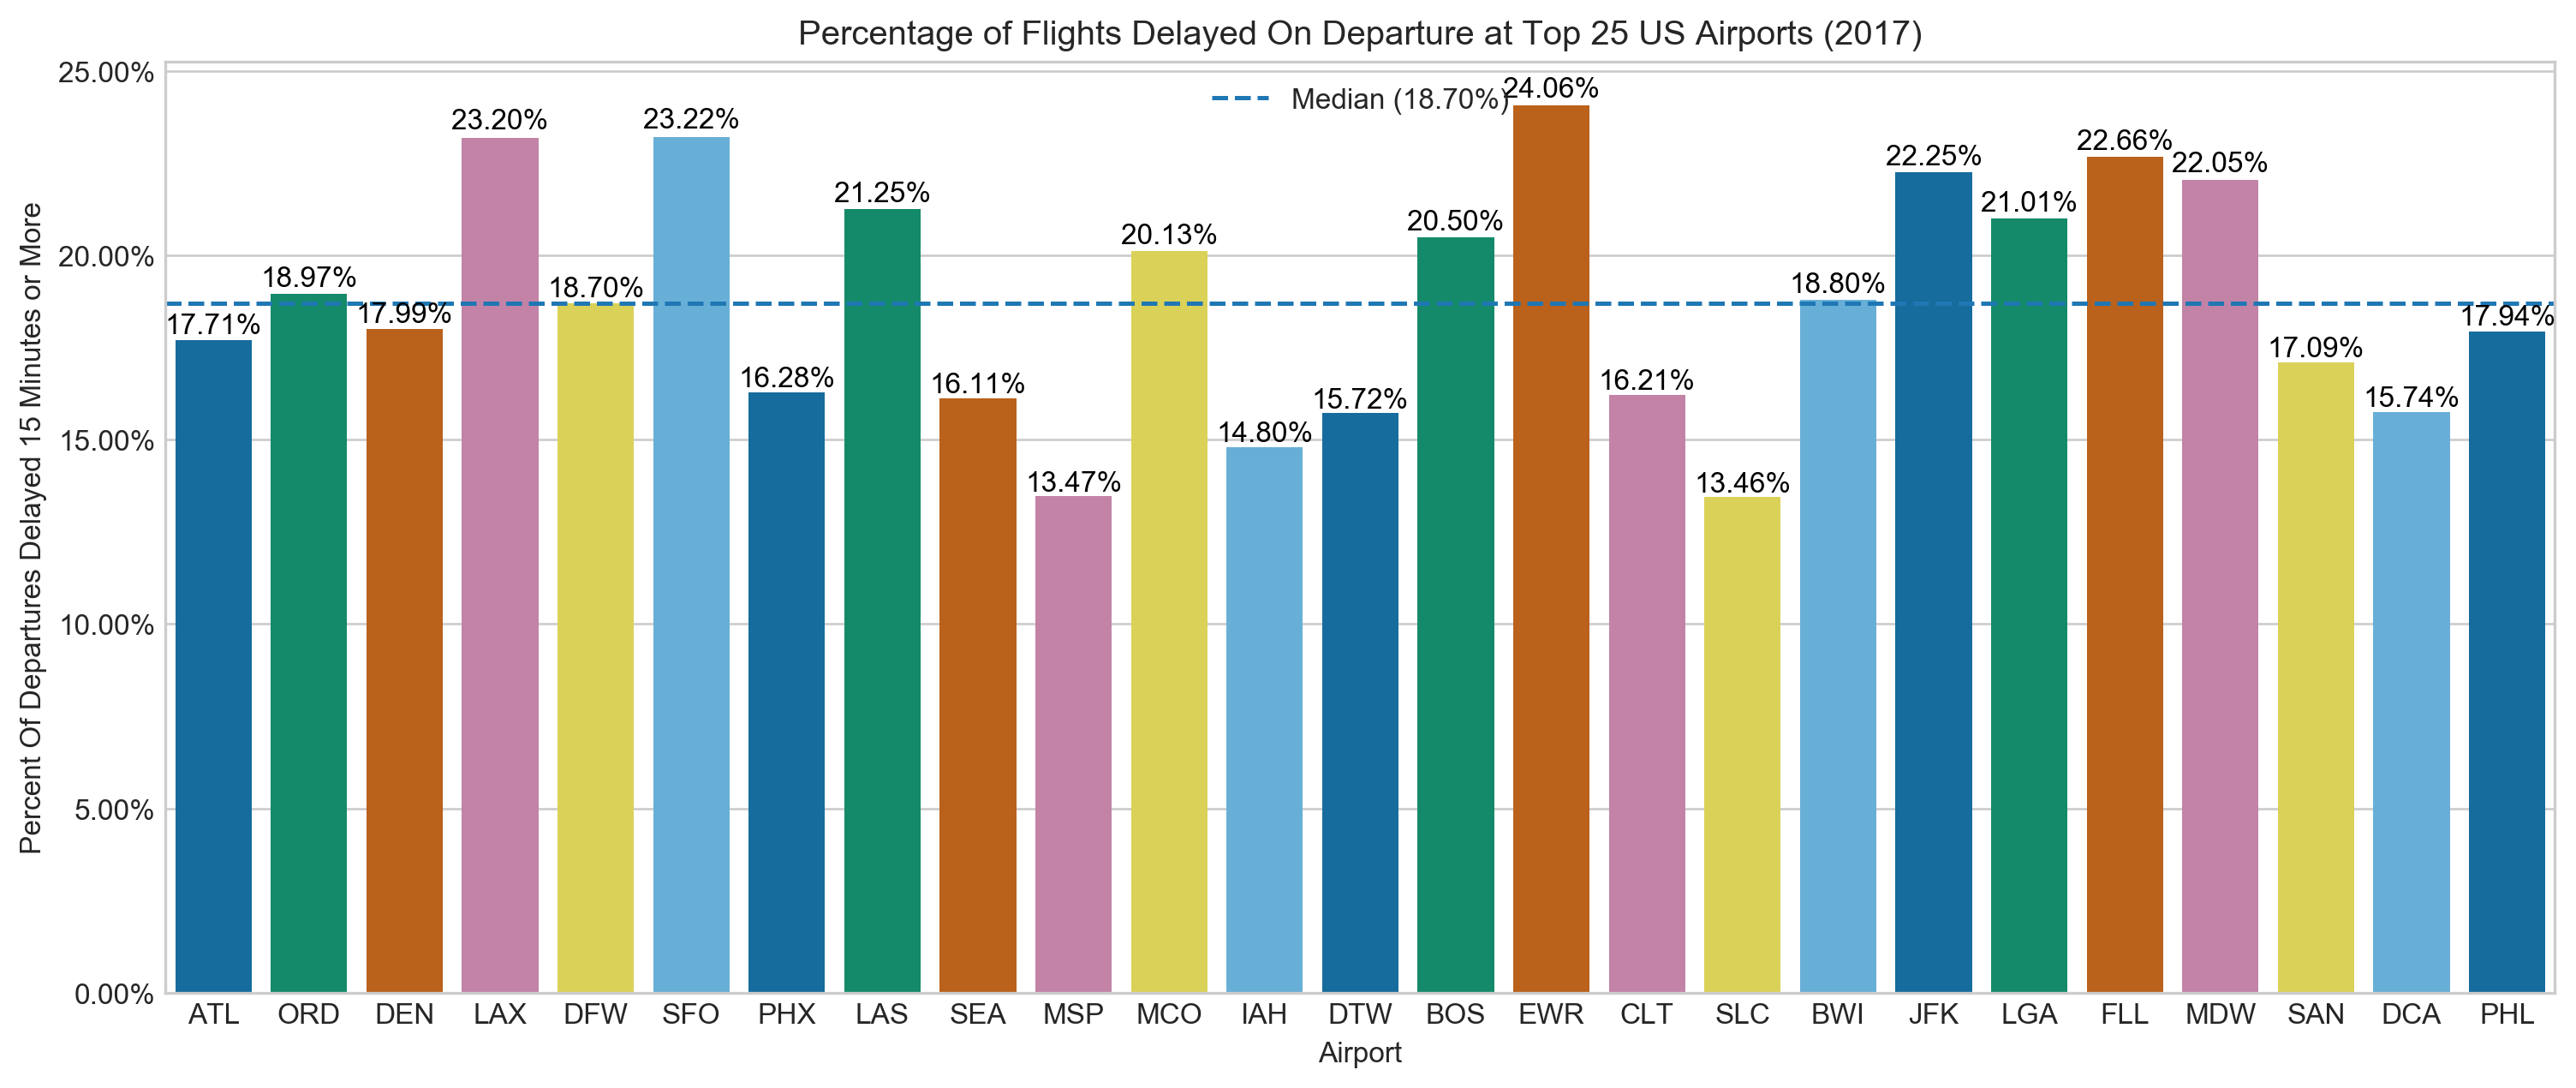

In [61]:
def plot_rates_of_delay(data):
    count = len(data)
    
    ax, fig = plt.subplots(figsize=(15, 6), dpi=240)
    color = sns.color_palette('colorblind')
    ax = sns.barplot(
        x='origin_airport', 
        y='departure_delay_fraction', 
        data=data, 
        palette=color
    )
    plt.title(f'Percentage of Flights Delayed On Departure at Top {count} US Airports (2017)')
    plt.xlabel('Airport')
    plt.ylabel('Percent Of Departures Delayed 15 Minutes or More')

    median = data['departure_delay_fraction'].median()
    median_percent = '{:3.2f}%'.format(median * 100)
    hline = ax.axhline(
        y=data['departure_delay_fraction'].median(), 
        xmin=0, 
        xmax=1, 
        linestyle='--', 
        label=f'Median ({median_percent})',
    )


    vals = ax.get_yticks()
    ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])
    
    for p in ax.patches:
        height = p.get_height()
        label_string = '{:3.2f}%'.format(height * 100)
        ax.text(p.get_x()+p.get_width()/2.,
                height * 1.01,
                label_string,
                ha="center", color='black') 
    
    plt.legend(handles=[hline], loc='upper center')
    plt.savefig('../../reports/figures/busiest-airports-by-rate-of-departure-delay.png', bbox_inches='tight')
    plt.show()

plot_rates_of_delay(f.head(25).reset_index())

## Of the largest airports, what percentage of flights were delayed in 2017?

The rate of delays appears to vary greatly even among airports of similar size.  Newark (EWR), San Francisco (SFO), and Los Angeles (LAX) were the most frequently delayed among the largest 25 airports.  Salt Lake City (SLC) and Minneapolis-St.Paul (MSP) were the least frequently delayed upon departure in the BTS data.

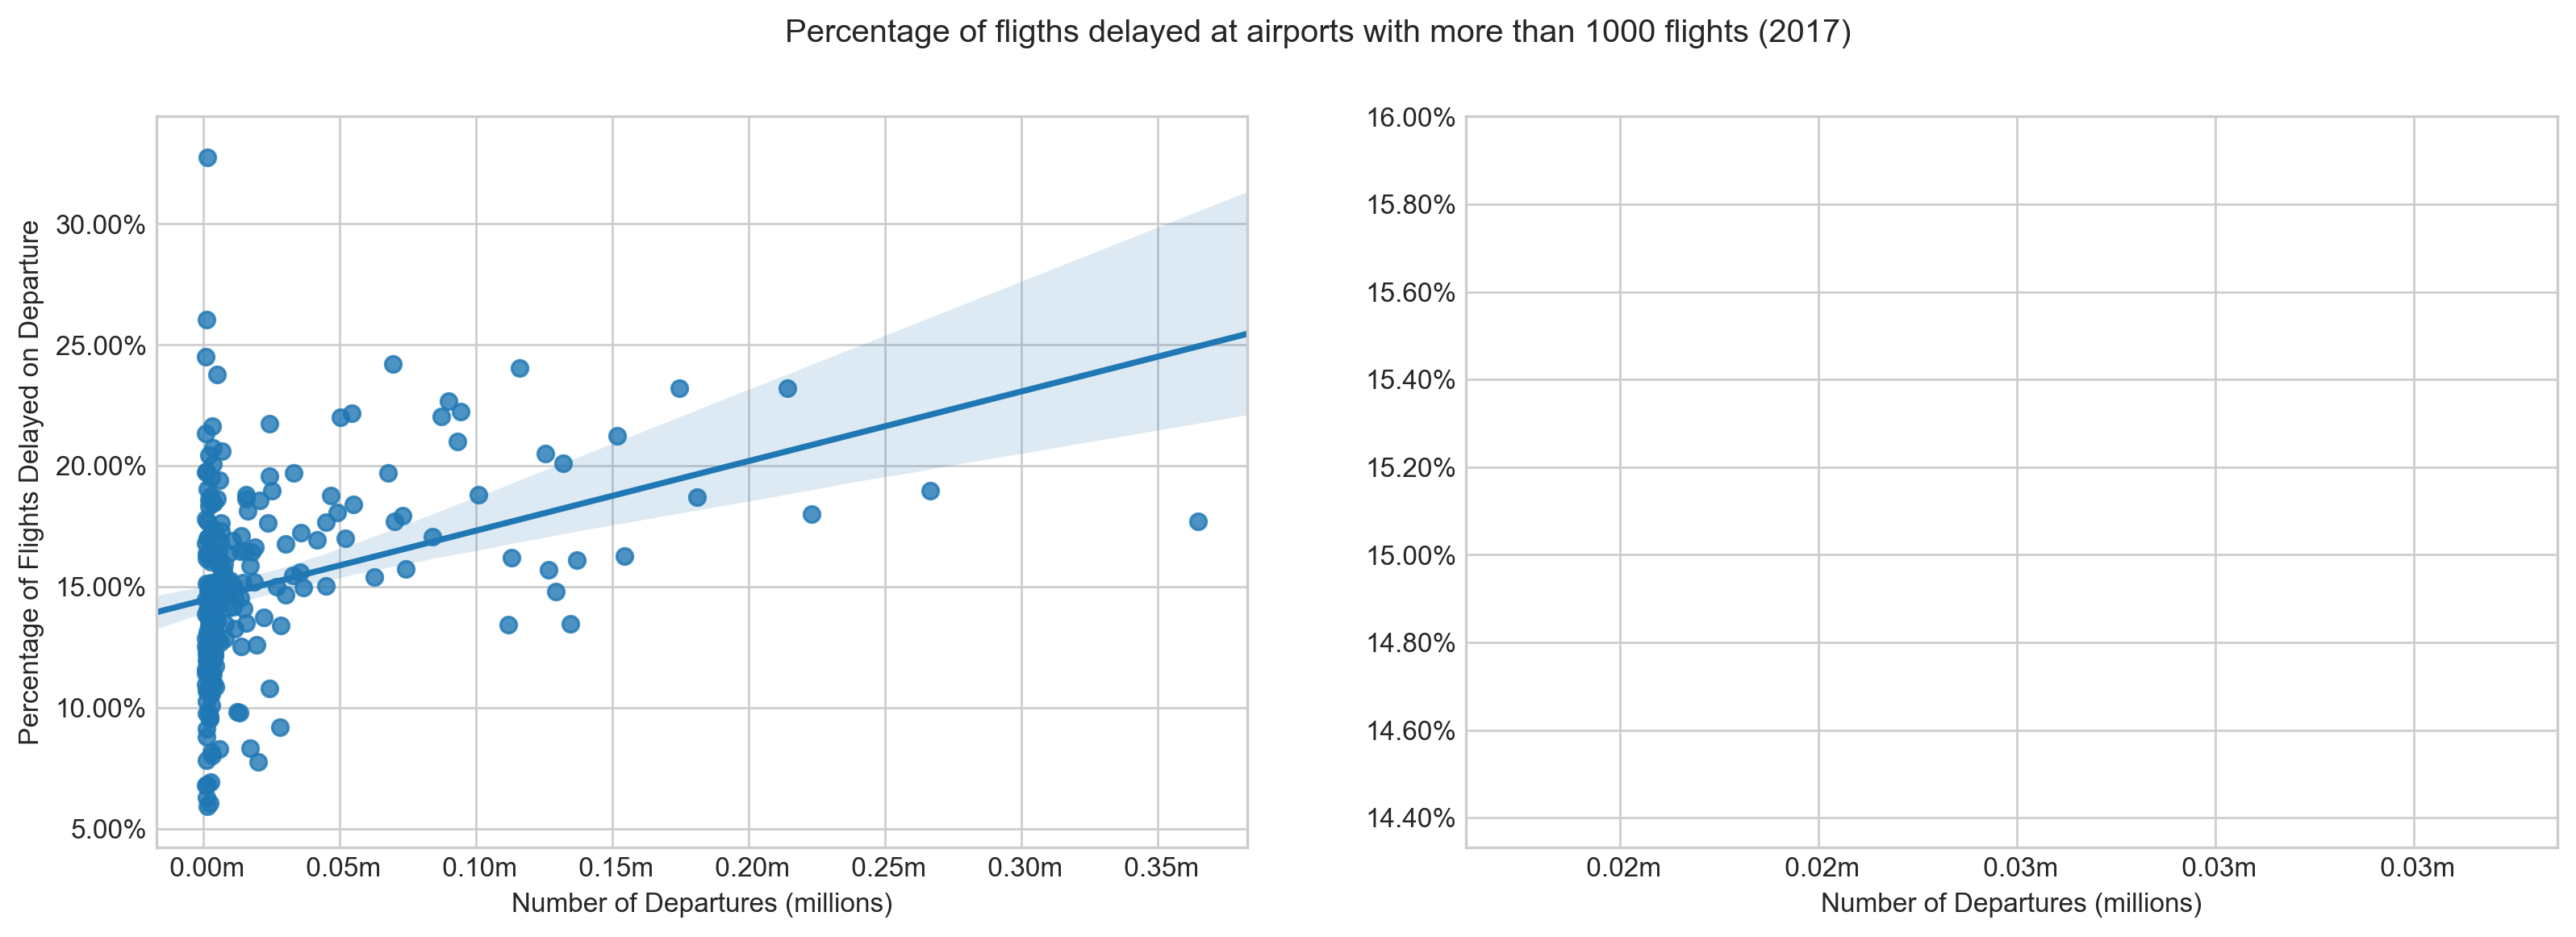

In [66]:
def plot_rates_of_delay_against_airport_size(data, minimum_flight_count=5000):
    d = data[data['departures'] > minimum_flight_count]

    a4_dims = (16, 5)
    color = sns.color_palette('colorblind')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=a4_dims, dpi=240)

    _ = sns.regplot(data=d, x='departures', y='departure_delay_fraction', fit_reg=True, ax=ax1)
    _ = ax1.set_ylabel('Percentage of Flights Delayed on Departure')

    _ = plt.suptitle(f"Percentage of fligths delayed at airports with more than {minimum_flight_count} flights (2017)")

    for ax in [ax1, ax2]:
        _ = ax.set_xlabel('Number of Departures (millions)')

        vals = ax.get_yticks()
        _ = ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

        one_million = 1e6
        vals = ax.get_xticks()
        _ = ax.set_xticklabels(['{:5.2f}m'.format(x / one_million) for x in vals])
    plt.savefig('../../reports/figures/airport-size-versus-rate-of-delay.png', bbox_inches='tight')
    plt.show()
    
plot_rates_of_delay_against_airport_size(f, 1000)

## How does the rate of delay vary with airport size?

Plotting the rate of delay against the number of departures does not indicate a strong relationship between airport size and the rates of delay.  This suggests that other factors may be better indicators of flight delays.